[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/9.0-seq2seq-NSYNTH.ipynb)

### Seq2Seq Autoencoder (without attention)  
Seq2Seq models use recurrent neural network cells (like LSTMs) to better capture sequential organization in data. This implementation uses Convolutional Layers as input to the LSTM cells, and a single Bidirectional LSTM layer. 

![a seq2seq bidirectional lstm in tensorflow 2.0](imgs/seq2seq.png)

### Install packages if in colab

In [ ]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
  process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
  for line in process.stdout:
      print(line.decode().strip())
      
import sys, subprocess
IN_COLAB = 'google.colab' in sys.modules
colab_requirements = [
    'pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513',
    'pip install librosa'
]
if IN_COLAB:
  for i in colab_requirements:
    run_subprocess_command(i)

### load packages

In [1]:
# make visible the only one GPU
#%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.io import FixedLenFeature, parse_single_example
from librosa.core.time_frequency import mel_frequencies
from pathlib2 import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import display
from tqdm.autonotebook import tqdm
%matplotlib inline

In [3]:
print(tf.__version__)

2.0.0-dev20190513


### Download or load dataset
Tensorflow datasets will automatically download or load the dataset for you at this location

In [4]:
DATA_DIR = Path("data").resolve()
DATA_DIR

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/tf2_gen_models/data')

In [5]:
ds_train, ds_test = tfds.load(
    name="nsynth", split=["train", "test"], data_dir=DATA_DIR
)

In [6]:
ds_train

<_OptionsDataset shapes: {id: (), audio: (64000,), pitch: (), velocity: (), instrument: {label: (), family: (), source: ()}, qualities: {bright: (), dark: (), distortion: (), fast_decay: (), long_release: (), multiphonic: (), nonlinear_env: (), percussive: (), reverb: (), tempo-synced: ()}}, types: {id: tf.string, audio: tf.float32, pitch: tf.int64, velocity: tf.int64, instrument: {label: tf.int64, family: tf.int64, source: tf.int64}, qualities: {bright: tf.bool, dark: tf.bool, distortion: tf.bool, fast_decay: tf.bool, long_release: tf.bool, multiphonic: tf.bool, nonlinear_env: tf.bool, percussive: tf.bool, reverb: tf.bool, tempo-synced: tf.bool}}>

### Prepare spectrogramming and parameters

In [7]:
def _normalize_tensorflow(S, hparams):
    return tf.clip_by_value((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)

def _tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def _amp_to_db_tensorflow(x):
    return 20 * _tf_log10(tf.clip_by_value(tf.abs(x), 1e-5, 1e100))


def _stft_tensorflow(signals, hparams):
    return tf.signal.stft(
        signals,
        hparams.win_length,
        hparams.hop_length,
        hparams.n_fft,
        pad_end=True,
        window_fn=tf.signal.hann_window,
    )


def spectrogram_tensorflow(y, hparams):
    D = _stft_tensorflow(y, hparams)
    S = _amp_to_db_tensorflow(tf.abs(D)) - hparams.ref_level_db
    return _normalize_tensorflow(S, hparams)

In [8]:
class HParams(object):
    """ Hparams was removed from tf 2.0alpha so this is a placeholder
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [9]:
hparams = HParams( 
    # network
    batch_size = 32,
    # spectrogramming
    sample_rate = 16000,
    create_spectrogram = True,
    win_length = 1024,
    n_fft = 1024,
    hop_length= 400,
    ref_level_db = 50,
    min_level_db = -100,
    # mel scaling
    num_mel_bins = 128,
    mel_lower_edge_hertz = 0,
    mel_upper_edge_hertz = 8000,
    # inversion
    power = 1.5, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
    #
)

### Create the dataset class

In [10]:
class NSynthDataset(object):
    def __init__(
        self,
        tf_records,
        hparams,
        is_training=True,
        test_size = 1000,
        prefetch=1000, # how many spectrograms to prefetch
        num_parallel_calls=10, # how many parallel threads should be preparing data
        n_samples = 305979, # how many items are in the dataset
        shuffle_buffer = 1000,
    ):
        self.is_training = is_training
        self.nsamples = n_samples
        self.test_size = test_size
        self.hparams = hparams
        self.prefetch = prefetch
        self.shuffle_buffer = shuffle_buffer
        # prepare for mel scaling
        if self.hparams.create_spectrogram:
            self.mel_matrix = self._make_mel_matrix()
        # create dataset of tfrecords
        self.raw_dataset = tf.data.TFRecordDataset(tf_records)
        # prepare dataset iterations
        self.dataset = self.raw_dataset.map(
            lambda x: self._parse_function(x), num_parallel_calls=num_parallel_calls
        )
        # make and split train and test datasets
        self.prepare_datasets()
        
    def prepare_datasets(self):
        # Note: there are better ways to do batching and shuffling here:
        #    https://www.tensorflow.org/guide/performance/datasets
        
        self.dataset_train = self.dataset.skip(self.test_size)
        self.dataset_train = self.dataset_train.shuffle(self.shuffle_buffer)
        self.dataset_train = self.dataset_train.prefetch(self.prefetch)
        self.dataset_train = self.dataset_train.batch(hparams.batch_size)
        
        
        self.dataset_test = self.dataset.take(self.test_size)
        self.dataset_test = self.dataset_test.shuffle(self.shuffle_buffer)
        self.dataset_test = self.dataset_test.prefetch(self.prefetch)
        self.dataset_test = self.dataset_test.batch(hparams.batch_size)
        
        
        
    def _make_mel_matrix(self):
        # create mel matrix
        mel_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=self.hparams.num_mel_bins,
            num_spectrogram_bins=int(self.hparams.n_fft / 2) + 1,
            sample_rate=self.hparams.sample_rate,
            lower_edge_hertz=self.hparams.mel_lower_edge_hertz,
            upper_edge_hertz=self.hparams.mel_upper_edge_hertz,
            dtype=tf.dtypes.float32,
            name=None,
        )
        # gets the center frequencies of mel bands
        mel_f = mel_frequencies(
            n_mels=hparams.num_mel_bins + 2,
            fmin=hparams.mel_lower_edge_hertz,
            fmax=hparams.mel_upper_edge_hertz,
        )
        # Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
        enorm = tf.dtypes.cast(
            tf.expand_dims(tf.constant(2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[:hparams.num_mel_bins])), 0),
            tf.float32,
        )
        # normalize matrix
        mel_matrix = tf.multiply(mel_matrix, enorm)
        mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))
        
        return mel_matrix

    def print_feature_list(self):
        # get the features
        element = list(self.raw_dataset.take(count=1))[0]
        # parse the element in to the example message
        example = tf.train.Example()
        example.ParseFromString(element.numpy())
        print(list(example.features.feature))

    def _parse_function(self, example_proto):
        """ There are a number of features here (listed above). 
        I'm only grabbing a few here
        """
        features = {
            "id": FixedLenFeature([], dtype=tf.string),
            "pitch": FixedLenFeature([1], dtype=tf.int64),
            "velocity": FixedLenFeature([1], dtype=tf.int64),
            "audio": FixedLenFeature([64000], dtype=tf.float32),
            "instrument/source": FixedLenFeature([1], dtype=tf.int64),
            "instrument/family": FixedLenFeature([1], dtype=tf.int64),
            "instrument/label": FixedLenFeature([1], dtype=tf.int64),
        }
        example = parse_single_example(example_proto, features)

        if self.hparams.create_spectrogram:
            # create spectrogram
            example["spectrogram"] = spectrogram_tensorflow(
                example["audio"], self.hparams
            )
            # create melspectrogram
            example["spectrogram"] = tf.expand_dims(
                tf.transpose(tf.tensordot(
                    example["spectrogram"], self.mel_matrix, 1
            )), axis=2
            )
            
        return example

### Produce the dataset from tfrecords

In [11]:
training_tfrecords = [str(i) for i in list((DATA_DIR / "nsynth").glob('**/*train.tfrecord*'))]

In [12]:
dset = NSynthDataset(training_tfrecords, hparams)

In [13]:
ex = next(iter(dset.dataset_test))

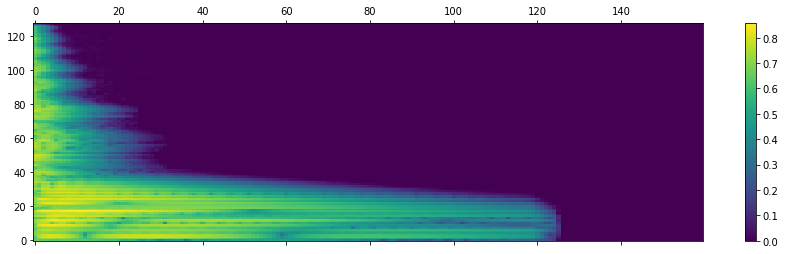

In [14]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(np.squeeze(ex["spectrogram"].numpy()[0]), aspect='auto', origin='lower')
fig.colorbar(cax)

In [ ]:
spec_shape = np.shape(ex["spectrogram"].numpy()[10])
spec_shape

(128, 160, 1)

### Define the network as tf.keras.model object

In [ ]:
class AE(tf.keras.Model):
    """a basic autoencoder class for tensorflow
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(AE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    @tf.function
    def encode(self, x):
        return self.enc(x)

    @tf.function
    def decode(self, z):
        return self.dec(z)

    @tf.function
    def compute_loss(self, x):
        z = self.encode(x)
        _x = self.decode(z)
        ae_loss = tf.reduce_mean(tf.square(x - _x))
        return ae_loss

    @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

### Define the network architecture

In [ ]:
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM,
)

# from tensorflow.keras.layers import UnifiedLSTM as LSTM

N_Z = 512
shape_final = (8, 10, 128)  # x channel will be the sequence length

enc = [
    Conv2D(
        filters=16, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    Conv2D(
        filters=shape_final[2],
        kernel_size=3,
        strides=(2, 2),
        activation="relu",
        padding="same",
    ),
    Reshape(target_shape=(shape_final[0], np.prod(shape_final[1:]))),
    Bidirectional(LSTM(units=100, activation="relu")),
    Dense(units=512),
    Dense(units=N_Z),
]

dec = [
    Dense(units=512),
    RepeatVector(shape_final[0]),
    Bidirectional(LSTM(units=100, activation="relu", return_sequences=True)),
    TimeDistributed(Dense(np.prod(shape_final[1:]))),
    Reshape(target_shape=(shape_final[0], shape_final[1], shape_final[2])),
    tf.keras.layers.Conv2DTranspose(
        filters=shape_final[2],
        kernel_size=3,
        strides=(2, 2),
        padding="SAME",
        activation="relu",
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=16, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=1, strides=(1, 1), activation="sigmoid"
    ),
    Reshape(target_shape=spec_shape),
]

### Create Model

In [ ]:
# optimizers
optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

# model
model = AE(
    enc = enc,
    dec = dec,
    optimizer = optimizer,
)

In [ ]:
# exampled data for plotting results
example_data = next(iter(dset.dataset_test))['spectrogram']
example_data.shape

TensorShape([32, 128, 160, 1])

In [ ]:
ex_z = model.encode(example_data)
print(ex_z.shape)

(32, 512)


In [ ]:
ex_x = model.decode(ex_z)
print(ex_x.shape)

(32, 128, 160, 1)


### Train model

In [ ]:
def plot_reconstruction(model, example_data, nex=5, zm=2):

    example_data_reconstructed = model.decode(model.encode(example_data))
    fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(zm * nex, zm * 2))
    for exi in range(nex):
        axs[0, exi].matshow(
            example_data.numpy()[exi].squeeze(), cmap=plt.cm.viridis, vmin=0, vmax=1,
            origin = 'lower'
        )
        axs[1, exi].matshow(
            example_data_reconstructed.numpy()[exi].squeeze(),
            cmap=plt.cm.viridis,
            vmin=0,
            vmax=1,
            origin = 'lower'
        )
    for ax in axs.flatten():
        ax.axis("off")
    plt.show()

In [ ]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['MSE'])

In [ ]:
n_batches_train = int(dset.nsamples/hparams.batch_size)
n_batches_test = int(dset.test_size/hparams.batch_size)
n_batches_train, n_batches_test

(9561, 31)

In [ ]:
# lets make epochs smaller so we can visualize training faster
n_batches_train = 200

Epoch: 42 | MSE: 0.0039087627083063126


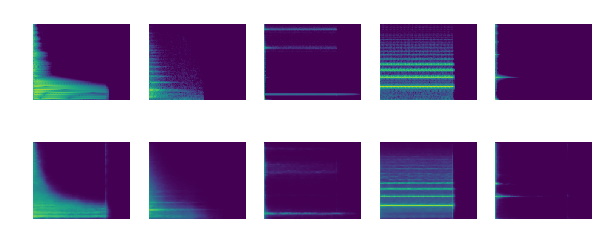

In [ ]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(n_batches_train), dset.dataset_train), total=n_batches_train
    ):
        model.train(train_x['spectrogram'])
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(n_batches_test), dset.dataset_test), total=n_batches_test
    ):
        loss.append(model.compute_loss(test_x['spectrogram']))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | MSE: {}".format(
            epoch, losses.MSE.values[-1]
        )
    )
    plot_reconstruction(model, example_data)